In [1]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app

# Neural Network (NN) from scratch

Goal is to reproduce TensorFlow's Sequential from scratch.

Focus for now is on single output.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List


# Import partial functions
from functools import partial

## Forward Propagation

Class of Layer and NN with only forward propagation

In [207]:
class Layer():
    '''
    Class for each layer of the NN.
    '''
    def sigmoid(self, vec):
        return 1 / (1 + np.exp(-vec))
    
    def softplus(self, vec):
        return np.log(1 + np.exp(vec))

    def relu(self, vec):
        return np.maximum(vec, 0)
    
    def linear(self, vec):
        return vec

    def set_inputs(self, inputs):
        units = self.units
        self.inputs = inputs

        # Setup weights vector
        self.weights = np.zeros((inputs, units))


    def __init__(self, units, inputs=1, activation='reLU'):
        '''
        Initialization

        Variables:
        units - # of units, int
        inputs - # of inputs, int

        activation - activation func, function

        weights - ndarray (inputs, units), dtype = float64
        bias - ndarray (1, units), dtype = float64

        '''
        self.units = units


        if activation == "sigmoid":
            self.activation = self.sigmoid
        elif activation == "softplus":
            self.activation = self.softplus
        elif activation == "reLU":
            self.activation = self.relu
        else:
            # linear as default activation function
            self.activation = self.linear

        self.bias = np.zeros((1, units))

        self.set_inputs(inputs)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass
        
        Parameters:
        input_vector : ndarray (# training examples, # features)
        
        Returns:
        output_vector : ndarray(units, 1)
        '''
        x = (np.matmul(input_vector, self.weights)) + self.bias
        return self.activation(x)
    
    __call__ = forward_pass
    
    def set_weights(self, weight_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        weight_vector : ndarray (inputs, units)
        '''

        self.weights = weight_vector

    def set_bias(self, bias_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        bias_vector : ndarray (1, units), dtype = float64
        '''

        self.bias = bias_vector 
    

        
# Basic test
test = Layer(2, inputs=2)

test_a1 = np.array([[1, 2]])

print(test.weights)
test.set_weights(np.array([[1.5, 0.3],[2.6, 0.8]]))
test.set_bias(np.array([[1.2,1.4]]))

test(test_a1)

assert np.array_equal(test(test_a1),np.array([[7.9, 3.3]]))



[[0. 0.]
 [0. 0.]]


In [218]:
class NeuralNetwork():
    '''
    Neural Network class
    '''
    def __init__(self, layers : List[Layer]):
        '''
        Setup Neural Network from a list of layers

        Initializes inputs automatically besides the first layer
        '''

        self.layers = layers

        for i in range(1, len(layers)):
            prev_layer_outputs = layers[i - 1].weights.shape[1]

            layers[i].set_inputs(prev_layer_outputs)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass thru whole network
        
        Parameters:
        input_vector : ndarray (# training examples, # features)
        
        Returns:
        output_vector : ndarray (units, 1)
        '''

        for i in range(len(self.layers)):
            input_vector = self.layers[i].forward_pass(input_vector)
        return input_vector
    
    __call__ = forward_pass


### Testing from simple NN given in StatQuest video

ReLU Test - Looks good


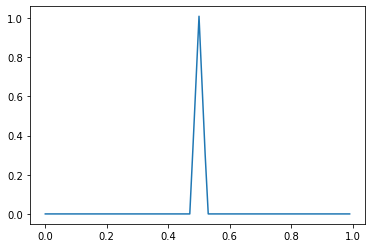

In [221]:
layer1 = Layer(2)

output_layer = Layer(1)
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

# print(layer1.weights, layer1.bias, output_layer.weights, output_layer.bias)
layer1.set_weights(np.array([[1.7,12.6]]))
layer1.set_bias(np.array([[-.85,-.00]]))


output_layer.set_weights(np.array([[-40.8], [2.7]]))
output_layer.set_bias(np.array([[-16]]))

t = np.arange(0, 1, 0.01).reshape((-1, 1))
plt.plot(t.flatten(), test_from_statquest(t).flatten())

Softplus test - looks good, from statquest

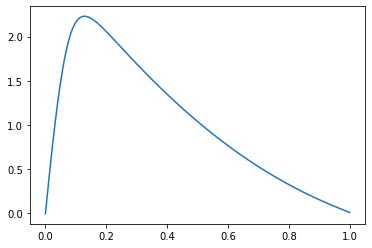

In [220]:
layer1 = Layer(2, activation="softplus")

output_layer = Layer(1, activation="linear")
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

layer1.set_weights(np.array([[-34.4,-2.52]]))
layer1.set_bias(np.array([[2.14,1.29]]))


output_layer.set_weights(np.array([[-1.30], [2.28]]))
output_layer.set_bias(np.array([[-.58]]))


t = np.arange(0, 1, 0.001).reshape((-1, 1))
plt.plot(t.flatten(), test_from_statquest(t).flatten())


## Backpropagation

Implementation of backpropagation. Doesn't use matrix calculus; possibly inefficient algorithm as a result (goes through weights one by one)

In [8]:
class Layer():
    '''
    Class for each layer of the NN.
    '''
    def sigmoid(self, vec):
        return 1 / (1 + np.exp(-vec))
    
    def softplus(self, vec):
        return np.log(1 + np.exp(vec))

    def relu(self, vec):
        return np.maximum(vec, 0)
    
    def linear(self, vec):
        return vec

    def softplus_derivative(self, input_vector : np.ndarray):
        '''
        Returns derivative of Softplus.

        Derivative is equivalent to sigmoid.

        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        output_vector : ndarray (inputs, 1)
        '''

        return self.sigmoid(input_vector)

    def relu_derivative(self, input_vector : np.ndarray):
        '''
        Returns derivative of ReLu.

        d max(x, 0)/dx = 1 for x > 0, 0 for x < 0. Derivative for x = 0 is defined to be 0.

        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        output_vector : ndarray (inputs, 1)
        '''

        return (input_vector > 0).astype(float)
    

    def linear_derivative(self, input_vector : np.ndarray):
        '''
        Returns derivative of linear.

        Derivative is equivalent to 1.

        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        output_vector : ndarray (inputs, 1)
        '''

        return np.ones(input_vector.shape)

    def set_inputs(self, inputs):
        units = self.units
        self.inputs = inputs

        # Setup weights vector to random weights in a normal distribution N(0, 1)
        self.weights = np.random.normal(size=(inputs, units))


    def __init__(self, units, inputs=1, activation='reLU'):
        '''
        Initialization

        Variables:
        units - # of units, int
        inputs - # of inputs, int

        activation - activation func, function

        weights - ndarray (inputs, units), dtype = float64
        bias - ndarray (1, units), dtype = float64

        '''
        self.units = units


        if activation == "sigmoid":
            self.activation = self.sigmoid
        elif activation == "softplus":
            self.activation = self.softplus
            self.activation_derivative = self.softplus_derivative
        elif activation == "reLU":
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        else:
            # linear as default activation function
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative

        self.bias = np.zeros((1, units))

        self.set_inputs(inputs)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass
        
        Parameters:
        input_vector : ndarray (# training examples, # features)

        Returns:
        output_vector : ndarray(units, 1)
        '''
        x = (np.matmul(input_vector, self.weights)) + self.bias
        return self.activation(x)
    
    __call__ = forward_pass

    def forward_pass_with_pre_activation(self, input_vector : np.ndarray):
        '''
        Forward pass
        
        Parameters:
        input_vector : ndarray (# training examples, # features)


        Returns:
        pre_activation_vector - vector before activation function : ndarray(units, 1)
        output_vector : ndarray(units, 1)
        '''
        x = (np.matmul(input_vector, self.weights)) + self.bias
        return x, self.activation(x)
    
    
    def set_weights(self, weight_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        weight_vector : ndarray (inputs, units)
        '''

        self.weights = weight_vector

    def set_bias(self, bias_vector : np.ndarray):
        '''
        Manually set weights

        Parameters:
        bias_vector : ndarray (1, units), dtype = float64
        '''

        self.bias = bias_vector 
        
# Basic test
test = Layer(2, inputs=2)

test_a1 = np.array([[1, 2]])

print(test.weights)
test.set_weights(np.array([[1.5, 0.3],[2.6, 0.8]]))
test.set_bias(np.array([[1.2,1.4]]))

test(test_a1)

assert np.array_equal(test(test_a1),np.array([[7.9, 3.3]]))



[[-1.57739794  0.39687725]
 [ 0.49127531 -0.36736464]]


In [95]:
class NeuralNetwork():
    '''
    Neural Network class
    '''
    def layer_set_weight(self, prev_set_weight_func, index, weight_vector : np.ndarray):
        '''
        Overrides a layer's set_weight function and updates the internal weight array.
        '''
        prev_set_weight_func(weight_vector)

        self.weights[index] = weight_vector
    
    def layer_set_bias(self,prev_set_bias_func, index, bias_vector : np.ndarray):
        '''
        Overrides a layer's set_bias function and updates the internal bias array.
        '''
        prev_set_bias_func(bias_vector)

        self.bias[index] = bias_vector


    def __init__(self, layers : List[Layer]):
        '''
        Setup Neural Network from a list of layers

        Initializes inputs automatically besides the first layer

        Variables:
        Layers : # of layers, int
        Weights : [weights separated by layer], list of ndarray
        Bias : [biases by layer], list of ndarrays
        '''

        self.layers = layers
        self.num_layers = len(layers)
        self.weights = [layers[0].weights]
        self.bias = [layers[0].bias]

        # Reassign set_weights and set_bias functions
        for i in range(self.num_layers):

            self.layers[i].set_weights = partial(self.layer_set_weight, self.layers[i].set_weights, i)
            self.layers[i].set_bias = partial(self.layer_set_bias, self.layers[i].set_bias, i)

        for i in range(1, len(layers)):
            prev_layer_outputs = layers[i - 1].weights.shape[1]

            layers[i].set_inputs(prev_layer_outputs)
            
            self.weights.append(layers[i].weights)
            self.bias.append(layers[i].bias)
        
        print("Weights before", self.weights)

    def forward_pass(self, input_vector : np.ndarray):
        '''
        Forward pass thru whole network
        
        Parameters:
        input_vector : ndarray (# training examples, # features (# inputs of first layer))

        Returns:
        output_vector : ndarray (units, 1)
        '''
        for i in range(len(self.layers)):
            input_vector = self.layers[i].forward_pass(input_vector)
        return input_vector

    def mean_squared_error(self, input_vector : np.ndarray, output : np.ndarray):
        '''
        Calculates Mean Squared Error for a given input_vector and the accompanying predicted vector.

        Parameters:
        input_vector : ndarray(# training examples, inputs)
        output : ndarray(# training examples, 1)

        Returns:
        MSE - float
        '''

        return np.mean((output - self.forward_pass(input_vector)) ** 2)


    
    __call__ = forward_pass


    def forward_pass_for_backprop(self, input_vector : np.ndarray):
        '''
        Forward pass thru whole network. Stores each unit's activation and pre-activation values for backprop.
        
        Parameters:
        input_vector : ndarray (inputs, 1)

        Returns:
        preactivation_values - all of the activations before entered into thet activation func per layer : [ndarray (some num, 1)]
        activation_values - all of the activations per layer : [ndarray (some num, 1)]
        activation_vec - final output of NN : [ndarray (1, nun_outputs)]
        '''

        activation_values = [input_vector]
        preactivation_values = [input_vector]

        activation_vec = input_vector


        for i in range(len(self.layers)):
            preactivation_vec, activation_vec = self.layers[i].forward_pass_with_pre_activation(activation_vec)

            activation_values.append(activation_vec)
            preactivation_values.append(preactivation_vec)

        # ACTIVATION VEC IS SINGLE OUTPUT - IF REVAMPING, SHOULD CHANGE!
        return preactivation_values, activation_values, activation_vec[0][0]

    def backward_pass(self, preactivation_values, activation_values, predicted, observed):
        '''
        One backward pass for one training example.

        Parameters:
        preactivation_values - all of the activations before entered into thet activation func per layer (this is a list) : [ndarray (some num, 1)]
        activation_values - all of the activations per layer (this is a list) : [ndarray (some num, 1)]

        predicted - predicted value (int for now - single output) : int
        observed - observed value (again, single output - int for now) : int
        lr - learning rate : float
        '''
        # Reversed order - from last layer to first
        new_weights = []
        new_bias = []

        d_mse_wrt_predicted = -2 * (observed - predicted)

        chain_rule_multiplier = None
        
        # Start from reverse
        for i in range(self.num_layers - 1, -1, -1):
            derivative_layer = self.layers[i].activation_derivative(preactivation_values[i + 1])
            
            d_weights_wrt_activation = np.multiply(derivative_layer, activation_values[i].T)

            d_bias_wrt_activation = derivative_layer

            # if chain_rule_multiplier
            if chain_rule_multiplier is not None:
                d_weight = np.multiply(chain_rule_multiplier, d_weights_wrt_activation)
                d_bias = np.multiply(chain_rule_multiplier, d_bias_wrt_activation)

                chain_rule_multiplier = np.matmul(chain_rule_multiplier, np.multiply(derivative_layer.T, self.weights[i].T))
            else:
                d_weight = d_weights_wrt_activation
                d_bias = d_bias_wrt_activation
                chain_rule_multiplier = np.multiply(derivative_layer, self.weights[i].T)


            # Includes with respect to entire mean squared func and learning rate
            d_weight = d_weight * d_mse_wrt_predicted
            d_bias = d_bias * d_mse_wrt_predicted

            new_weights.append(d_weight)
            new_bias.append(d_bias)
        
        new_weights.reverse()
        new_bias.reverse()

        return new_weights, new_bias



    def fit(self, x_train, y_train, num_epochs=1, lr = 0.01):
        '''
        Fits the data using backpropagation + gradient descent.

        Parameters - x_train : ndarray(# of training examples, inputs)
        Parameters - y_train : ndarray(# of training examples, 1) [only 1 output for now]

        Returns:
        error_history - history of errors: list of floats
        '''
        num_training_examples = x_train.shape[0]

        error_history = [self.mean_squared_error(x_train, y_train)]

        for epoch in range(num_epochs):
            change_weights = None
            change_bias = None

            # Iterate thru all examples - true batch gradient descent
            for i in range(num_training_examples):
                preact_vec, act_vec, predicted = self.forward_pass_for_backprop(x_train[i, None])
                if change_weights is None:
                    change_weights, change_bias = self.backward_pass(preact_vec, act_vec, predicted, y_train[i])
                else:
                    temp_weights, temp_bias = self.backward_pass(preact_vec, act_vec, predicted, y_train[i])

                    for i in range(len(temp_weights)):
                        change_weights[i] += temp_weights[i]
                        change_bias[i] += temp_bias[i]

            
            
            
            # Actually change weights
            for i in range(len(change_weights)):
                # lr * derivative of cost func (but haven't divided by n yet)
                self.weights[i] = self.weights[i] - lr * change_weights[i] / num_training_examples
                self.bias[i] = self.bias[i] - lr * change_bias[i] / num_training_examples

                self.layers[i].weights = self.weights[i]
                self.layers[i].bias = self.bias[i]

            # print("change by", change_weights, "weights", self.weights, "mse", self.mean_squared_error(x_train, y_train))
            
            error_history.append(self.mean_squared_error(x_train, y_train))
        
        return error_history


Test for worked out example of NN


In [94]:
# Test for NN -> worked out example
layer1 = Layer(2, inputs=1, activation="reLU")
layer2 = Layer(2, activation="reLU")

output_layer = Layer(1, activation="linear")
test_from_statquest = NeuralNetwork([
    layer1, layer2, output_layer
])

layer1.set_weights(np.array([[1,1]]))
layer1.set_bias(np.array([[0,0]]))


layer2.set_weights(np.array([[1,1], [1,1]]))
layer2.set_bias(np.array([[0,0]]))


output_layer.set_weights(np.array([[1], [1]]))
output_layer.set_bias(np.array([[0]]))


test_data = np.array([[0, 0], [5, 10], [10, 0]])

test_data_x = test_data[:,:-1]
test_data_y = test_data[:,-1]

# Output
print("Result", test_from_statquest(test_data_x))

# MSE of initial set
print("MSE", test_from_statquest.mean_squared_error(test_data_x, test_data_y))


# Comparing x 
# print(test_data_x, test_from_statquest(test_data_x))

# First example
# test_from_statquest.forward_pass_for_backprop(test_data_x[0, None])

# Backpropagation to first example
# test_from_statquest.fit(test_data_x[0, None], test_data_y[0, None])

x = 20
# Backpropagation for all examples in test_data
error_history = test_from_statquest.fit(test_data_x, test_data_y, num_epochs=x, lr=0.0001)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.7), layout='constrained')

x = np.arange(0,x + 1,1).reshape(-1,1)

ax1.plot(x, error_history)
ax1.set_title = "Training loss"

x = np.arange(0, 10, 0.01).reshape(-1,1)

ax2.plot(x, test_from_statquest(x))
ax2.set_title = "Final network"

ax3.plot(test_data_x, test_data_y)
ax3.set_title = "Test data"

print("Ending MSE", error_history[-1])

print("new weights", layer1.weights, layer1.bias, layer2.weights, layer2.bias)


# print(error_history)
print(test_from_statquest(np.array([[0]])), test_from_statquest(np.array([[5]])), test_from_statquest(np.array([[10]])))



Weights before [array([[-1.3944206 ,  2.01538532]]), array([[ 0.51033043,  1.61053698],
       [-1.22371466, -0.77869256]]), array([[-0.2598203 ],
       [ 1.21493907]])]
Result [[ 0]
 [20]
 [40]]
MSE 566.6666666666666
PLEASE FIX (1, 2) (2, 2) (1, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [78]:
#  more extreme test
layer1 = Layer(5)
layer2 = Layer(10)
layer3 = Layer(20)
output_layer = Layer(1)

test_from_statquest = NeuralNetwork([
    layer1, layer2, layer3, output_layer
])

# Backpropagation to first example
error_history = test_from_statquest.fit(test_data_x, test_data_y, num_epochs=1000, lr=0.0001)

print(layer1.weights)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.7), layout='constrained')

x = np.arange(0,1001,1).reshape(-1,1)

ax1.plot(x, error_history)
ax1.set_title = "Training loss"

x = np.arange(0, 1, 0.001).reshape(-1,1)

ax2.plot(x, test_from_statquest(x))
ax2.set_title = "Final network"

ax3.plot(test_data_x, test_data_y)


Weights before [array([[-0.582659  ,  0.59672254,  0.14441905,  2.6162328 , -0.84066625]]), array([[ 1.43724857e-01, -8.41988995e-01, -4.87154005e-01,
        -5.52259110e-01, -1.23126476e+00, -1.88836520e-01,
         5.02388159e-01, -8.30132558e-02, -5.85857854e-01,
        -1.67741399e-01],
       [ 5.60325017e-01, -3.29342213e-01, -1.06432872e+00,
        -3.19332910e-01,  6.80967693e-01, -7.38614045e-01,
         3.60513739e-01,  1.23652658e+00,  6.04769979e-01,
         2.84764943e-01],
       [-2.52359066e-01,  6.12999992e-01, -3.45119335e-02,
        -1.29648222e+00, -1.47143724e+00, -1.02729455e+00,
        -4.86750087e-01, -5.71487372e-04, -1.03309362e+00,
         1.32958113e+00],
       [-6.50210798e-01, -8.57043888e-01,  8.78194260e-01,
        -1.63731111e+00,  2.46233222e+00,  1.50795352e-01,
         5.10197739e-01, -4.42568439e-01, -9.06002282e-01,
         1.78779689e+00],
       [-6.28387203e-01, -1.22719710e-01,  1.67914097e+00,
        -1.01977957e-01, -5.51388340e

ValueError: operands could not be broadcast together with shapes (1,20) (20,10) 

In [53]:
# Test for neural network
layer1 = Layer(2, inputs=1)
layer2 = Layer(2)

output_layer = Layer(1)
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

layer1.set_weights(np.array([[1,1]]))
layer1.set_bias(np.array([[0,0]]))


output_layer.set_weights(np.array([[1], [1]]))
output_layer.set_bias(np.array([[0]]))


test_data = np.array([[0, 0], [0.5, 1], [1, 0]])

test_data_x = test_data[:,:-1]
test_data_y = test_data[:,-1:]


# Comparing x 
# print(test_data_x, test_from_statquest(test_data_x))

# First example
test_from_statquest.forward_pass_for_backprop(test_data_x[0, None])

# Backpropagation to first example
test_from_statquest.fit(test_data_x[0, None], test_data_y[0, None])

[array([[1., 1.]]), array([[1.],
       [1.]])] weights


[0.0, 0.0]

In [54]:
test = np.array([[2.], [1.]])

test * 2

array([[4.],
       [2.]])

2 layer 1 unit NN - easiest NN please back prop work

Weights before [array([[-0.86165093, -1.93949491]]), array([[-1.4003277 ],
       [ 0.45769433]])]
Result [[ 0.]
 [10.]
 [20.]]
MSE 133.33333333333334
weights at fit
[[1 1]]
[[1]
 [1]]
also weights [array([[1, 1]]), array([[1],
       [1]])]
MSE history [133.33333333333334, 131.21489070933336, 129.15497547000803, 127.15149057235395, 125.2024314451074, 123.30588115195489, 121.46000584697352, 119.66305050230946, 117.91333488962444, 116.20924979823866, 114.54925347418076, 112.93186826552821, 111.35567746050157, 109.81932230576757, 108.32149919331438, 106.86095700510415, 105.43649460547547, 104.04695847198316, 102.69124045601454, 101.36827566512767, 100.07704045961539, 98.81655055631235, 97.58585923313926, 96.38405562832148, 95.21026312862169, 94.06363784130842, 92.94336714492935, 91.84866831428255, 90.77878721528057, 89.73299706567978, 88.71059725790734, 87.71091224045855, 86.73329045456103, 85.7771033230102, 84.84174428827404, 83.92662789714544, 83.03118892938863, 82.15488156798187, 81.2

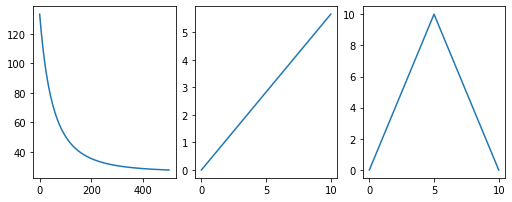

In [30]:
# Test for NN -> worked out example
layer1 = Layer(2, inputs=1, activation="reLU")

output_layer = Layer(1)
test_from_statquest = NeuralNetwork([
    layer1, output_layer
])

layer1.set_weights(np.array([[1, 1]]))
output_layer.set_weights(np.array([[1], [1]]))


test_data = np.array([[0, 0], [5, 10], [10, 0]])

test_data_x = test_data[:,:-1]
test_data_y = test_data[:,-1]

# Output
print("Result", test_from_statquest(test_data_x))

# MSE of initial set
print("MSE", test_from_statquest.mean_squared_error(test_data_x, test_data_y))


# Comparing x 
# print(test_data_x, test_from_statquest(test_data_x))

# First example
# test_from_statquest.forward_pass_for_backprop(test_data_x[0, None])

# Backpropagation to first example
# test_from_statquest.fit(test_data_x[0, None], test_data_y[0, None])

x = 500
# Backpropagation for all examples in test_data
error_history = test_from_statquest.fit(test_data_x, test_data_y, num_epochs=x, lr=0.00001)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.7), layout='constrained')

x = np.arange(0,x + 1,1).reshape(-1,1)

ax1.plot(x, error_history)
ax1.set_title = "Training loss"

x = np.arange(0, 10, 0.01).reshape(-1,1)

ax2.plot(x, test_from_statquest(x))
ax2.set_title = "Final network"

ax3.plot(test_data_x, test_data_y)
ax3.set_title = "Test data"

print("MSE history", error_history)


# print(error_history)
print(test_from_statquest(np.array([[0]])), test_from_statquest(np.array([[0.5]])), test_from_statquest(np.array([[1]])))



Sin function + some noise

In [70]:

layer1 = Layer(25, inputs=1, activation="softplus")
layer2 = Layer(10, activation="softplus")

output_layer = Layer(1, activation="linear")
test_from_statquest = NeuralNetwork([
    layer1, layer2, output_layer
])

sin_func_x = np.arange(0, 5, 0.01).reshape(-1,1)
sin_func_y = np.sin(sin_func_x) + np.random.normal(0, 0.05, 500).reshape(-1,1)

print()

Weights before [array([[-1.85032165, -0.56408168,  0.73779585,  1.29343292, -0.85376912,
        -0.19136849, -1.01004177, -0.75644727, -0.91518027,  1.36876527,
        -0.1425386 , -1.24710123, -1.56032083,  0.04244419,  1.05741665,
        -1.43940421,  2.07654978,  0.16978711,  0.4885613 , -0.43922125,
        -0.81097303, -0.30692907,  1.01606717, -1.10230084, -1.74248319]]), array([[ 1.53692127,  0.9852513 , -0.16850203,  0.55370546, -0.0235172 ,
        -1.78095908,  0.20306001,  1.14611755, -0.46472298, -0.86130506],
       [ 0.00476977,  0.1408741 ,  0.4094868 ,  0.64097319,  0.54198893,
        -1.23651586,  0.32604871, -1.09985146, -0.85821308, -1.93686475],
       [-0.29353541,  0.16392315,  0.26692019, -1.08912635, -0.09945228,
         1.77081119, -1.55987425,  0.94671111,  0.73777491, -0.55130252],
       [-0.40857949, -0.87961147,  0.13106892,  1.42865161, -0.75853791,
        -0.48534236, -0.28058383, -1.1604149 ,  1.12043654,  0.58519919],
       [ 0.60244606, -0.8826

0.1875543717527093


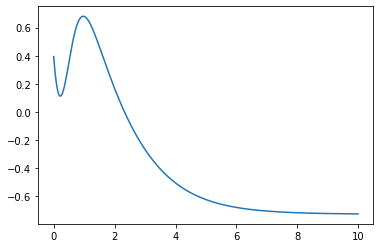

In [73]:
eh = test_from_statquest.fit(sin_func_x, sin_func_y, num_epochs=50)

print(eh[-1])

x = np.arange(0, 10, 0.01).reshape(-1,1)

plt.plot(x, test_from_statquest(x))